In [1]:
import nsepython
from portfoliotools.screener.stock_detail import StockDetail
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import scipy.stats as st

warnings.filterwarnings("ignore")
register_matplotlib_converters()
%matplotlib inline
sns.set()
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [67]:
class OptionHelper:
    
    def fnoList(self):
        return nsepython.fnolist()
    
    def smape_kun(self, y_true, y_pred):
        return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) +       np.abs(y_true))))
    
    def stockPrice(self, ticker, focus_period = 1000, lookback_period = 30, return_period = 1):
        stockObj = StockDetail(ticker, period = focus_period)
        prices = stockObj.calculate_return(return_period) # return_period Returns
        prices['Risk'] = prices['Return'].rolling( window = lookback_period).std()*np.sqrt(360/return_period) # return_period Risk
        prices['Return'] = prices['Return']*(360/return_period)
        return prices

    def predict(self, df):
        result = {
                'MSE'         : np.nan,
                'SMAPE KUN'    : np.nan,
                'Pred Value'   : np.nan,
                'SD' : np.nan,
                'Pred Low 50%'  : np.nan,
                'Pred High 50%' :np.nan,
                'Model':None
            }
        train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]

        train, test = train_data['data'].values, test_data['data'].values
        history = [x for x in train]
        predictions = list()
        p = 5
        d = 0
        q = 1
        for t in range(len(test)):
            model = ARIMA(history, order=(p,q,d))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
        error = mean_squared_error(test, predictions)
        result['MSE'] = np.round(error, 3)
        error2 = self.smape_kun(test, predictions)
        result['SMAPE KUN'] = np.round(error2, 3)

        model = ARIMA(history, order=(p,q,d))
        model_fit = model.fit(disp=0)
        result['Model'] = model_fit
        output = model_fit.forecast(alpha =0.5)
        result['Pred Value']  = np.round(output[0][0],2)
        result['SD']  = np.round(output[1][0],2)
        result['Pred Low 50%'] = np.round(output[2][0][0],2)
        result['Pred High 50%']= np.round(output[2][0][1],2)
        return result
    
    def optionChain(self, ticker):
        option_chain = nsepython.option_chain(ticker)
        result = []
        for data in option_chain['records']['data']:
            pe = data.get('PE', None)
            ce = data.get('CE', None)
            if pe is not None:
                result.append({
                    'strikePrice': data.get('strikePrice',0),
                    'expiryDate': data.get('expiryDate', ''),
                    'optionType': 'Put',
                    'closePrice': pe.get('lastPrice', 0),
                    'totalBuyQuantity': pe.get('totalBuyQuantity', 0),
                    'totalSellQuantity' : pe.get('totalSellQuantity', 0),
                    'openInterest' : pe.get('openInterest', 0),
                    'pchangeinOpenInterest' : pe.get('pchangeinOpenInterest', 0),
                    'identifier' : pe.get('identifier', ''),
                    'numberOfContractsTraded' : pe.get('totalTradedVolume', 0),
                    'impliedVolatility' : pe.get('impliedVolatility', 0),
                    'pChange' : pe.get('pChange', 0),
                    'underlyingValue' : pe.get('underlyingValue', 0),
                })
            if ce is not None:
                result.append({
                    'strikePrice': data.get('strikePrice',0),
                    'expiryDate': data.get('expiryDate', ''),
                    'optionType': 'Call',
                    'closePrice': ce.get('lastPrice', 0),
                    'totalBuyQuantity': ce.get('totalBuyQuantity', 0),
                    'totalSellQuantity' : ce.get('totalSellQuantity', 0),
                    'openInterest' : ce.get('openInterest', 0),
                    'pchangeinOpenInterest' : ce.get('pchangeinOpenInterest', 0),
                    'identifier' : ce.get('identifier', ''),
                    'numberOfContractsTraded' : ce.get('totalTradedVolume', 0),
                    'impliedVolatility' : ce.get('impliedVolatility', 0),
                    'pChange' : ce.get('pChange', 0),
                    'underlyingValue' : ce.get('underlyingValue', 0),
                })
        option_chain = pd.DataFrame(result)
        option_chain['expiryDate'] = option_chain['expiryDate'].apply(lambda x: datetime.strptime(x, '%d-%b-%Y').strftime('%Y-%m-%d'))
        expiryDates = option_chain['expiryDate'].unique()
        
        # Predict Price Range
        prices = self.stockPrice(ticker, focus_period = 365)
        data = prices[['Adj Close']]
        data.rename(columns={'Adj Close' : 'Close'}, inplace=True)
        # Expiry Dates
        daysToExpiry = [(datetime.strptime(d, '%Y-%m-%d') - datetime.now()).days for d in expiryDates]
        daysToExpiry = [z - round(z/7)*2 for z in daysToExpiry]
        forecast = {}
        i=0
        for days in daysToExpiry:
            data['Low_'+ str(days)] = data['Close'].rolling( window = days).min()
            data['Low_'+ str(days)] = data['Low_'+ str(days)].shift(-1*(days-1))
            data['High_'+ str(days)] = data['Close'].rolling( window = days).max()
            data['High_'+ str(days)] = data['High_'+ str(days)].shift(-1*(days-1))
            #data['Return_'+ str(days)] = (data['Close']/data['Close'].shift(days)-1)*100
            data['High_'+ str(days)] = ((data['High_'+ str(days)]/data['Close'])-1)*100
            data['Low_'+ str(days)] = ((data['Low_'+ str(days)]/data['Close'])-1)*100
            df_High = pd.DataFrame(data = data['High_'+ str(days)].values, columns = ['data'])
            df_Low = pd.DataFrame(data = data['Low_'+ str(days)].values, columns = ['data'])
            df_High.dropna(inplace=True)
            df_Low.dropna(inplace=True)
            temp = {}
            temp['High'] = self.predict(df_High)
            temp['Low'] = self.predict(df_Low)
            temp['DaysToExpiry'] = days
            forecast[expiryDates[i]] = temp
            i+=1
        # Append price ranges
        option_chain['predHighMean'] = option_chain['expiryDate'].apply(lambda x: forecast[x]['High']['Pred Value'])
        option_chain['predLowMean'] = option_chain['expiryDate'].apply(lambda x: forecast[x]['Low']['Pred Value'])
        option_chain['predHighSD'] = option_chain['expiryDate'].apply(lambda x: forecast[x]['High']['SD'])
        option_chain['predLowSD'] = option_chain['expiryDate'].apply(lambda x: forecast[x]['Low']['SD'])
        option_chain['daysToExpiry'] = option_chain['expiryDate'].apply(lambda x: forecast[x]['DaysToExpiry'])
        option_chain['ticker'] = ticker
        return option_chain

    def straddleCost(self, data):
        try:
            callPrice = list(data[data['optionType'] == 'Call']['closePrice'].values)[0]
            putPrice = list(data[data['optionType'] == 'Put']['closePrice'].values)[0]
            return callPrice + putPrice
        except:
            return 0

    def callPrice(self, data):
        try:
            callPrice = list(data[data['optionType'] == 'Call']['closePrice'].values)[0]
            return callPrice
        except:
            return 0

    def putPrice(self, data):
        try:
            putPrice = list(data[data['optionType'] == 'Put']['closePrice'].values)[0]
            return putPrice
        except:
            return 0

    def straddleBreakEven(self, data, direction = 'up', displayPercent = False):
        try:
            cost = self.straddleCost(data)
            strike = list(data['strikePrice'].values)[0]
            spot = list(data['underlyingValue'].values)[0]
            if direction == 'up':
                price = strike + cost
            else:
                price = strike - cost
            if displayPercent:
                if spot != 0:
                    return ((price - spot)*100 / spot)
                else:
                    np.nan
            else:
                return price
        except:
            return 0

    def groupImpliedVolatility(self, data, optionType = 'Call'):
        try:
            return list(data[data['optionType'] == optionType]['impliedVolatility'].values)[0]
        except:
            return 0

    def calStdProbITM(self, breakEven, current, iv, expiry, optionType = 'CALL'):
        delta = round(100-100*st.norm.cdf(np.log(breakEven/current)/(iv*.01 * np.sqrt(expiry/250))),2)
        if optionType == 'CALL':
            return delta
        else:
            return 100-delta
        
    def getStraddleStrategy(self, ticker):
        option_chain = self.optionChain(ticker)
        straddleDetails = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).agg({'numberOfContractsTraded' : sum, 
                                                                           'underlyingValue': max,
                                                                          'predHighMean': max,
                                                                          'predLowMean':max,
                                                                          'predHighSD':max,
                                                                          'predLowSD':max,
                                                                          'daysToExpiry':max})
        straddleDetails['call_price'] = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).apply(self.callPrice)
        straddleDetails['put_price'] = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).apply(self.putPrice)
        straddleDetails['cost'] = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).apply(self.straddleCost)
        straddleDetails['breakeven_up'] = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).apply(self.straddleBreakEven,'up')
        straddleDetails['breakeven_down'] = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).apply(self.straddleBreakEven,'down')
        straddleDetails['breakeven_up_per'] = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).apply(self.straddleBreakEven,'up', True)
        straddleDetails['breakeven_down_per'] = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).apply(self.straddleBreakEven,'down', True)
        straddleDetails['iv_pe'] = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).apply(self.groupImpliedVolatility,'Put')
        straddleDetails['iv_ce'] = option_chain.groupby(['ticker', 'expiryDate', 'strikePrice']).apply(self.groupImpliedVolatility,'Call')
        straddleDetails = straddleDetails[straddleDetails['numberOfContractsTraded'] > 0]
        straddleDetails = straddleDetails[straddleDetails['iv_ce'] > 0]
        straddleDetails = straddleDetails[straddleDetails['iv_pe'] > 0]

        straddleDetails = straddleDetails.reset_index()
        straddleDetails['cost_per'] = straddleDetails['cost'] *100/straddleDetails['underlyingValue']
        straddleDetails['probITMCall'] = straddleDetails[['strikePrice', 'call_price', 'underlyingValue', 'iv_ce', 'daysToExpiry']].apply(lambda x: self.calStdProbITM(x['strikePrice'] + x['call_price'],x['underlyingValue'],x['iv_ce'], x['daysToExpiry'], 'CALL'), axis=1)
        straddleDetails['probUpStd'] = straddleDetails[['breakeven_up', 'underlyingValue', 'iv_ce', 'daysToExpiry']].apply(lambda x: self.calStdProbITM(x['breakeven_up'],x['underlyingValue'],x['iv_ce'], x['daysToExpiry'], 'CALL'), axis=1)
        straddleDetails['probUpPredict'] = straddleDetails[['predHighMean', 'predHighSD','breakeven_up_per','cost_per','iv_ce', 'daysToExpiry']].apply(lambda x: round(100-st.norm.cdf((x['breakeven_up_per'] + x['cost_per']*.1 - x['predHighMean'])/max(x['predHighSD'],x['iv_ce'] * np.sqrt(x['daysToExpiry']/250)))*100,2), axis=1)
        straddleDetails['probITMPut'] = straddleDetails[['strikePrice', 'put_price', 'underlyingValue', 'iv_pe', 'daysToExpiry']].apply(lambda x: self.calStdProbITM(x['strikePrice'] - x['put_price'],x['underlyingValue'],x['iv_pe'], x['daysToExpiry'], 'PUT'), axis=1)
        straddleDetails['probDownStd'] = straddleDetails[['breakeven_down', 'underlyingValue', 'iv_pe', 'daysToExpiry']].apply(lambda x: self.calStdProbITM(x['breakeven_down'],x['underlyingValue'],x['iv_pe'], x['daysToExpiry'], 'PUT'), axis=1)
        straddleDetails['probDownPredict'] = straddleDetails[['predLowMean', 'predLowSD','breakeven_down_per','cost_per','iv_pe','daysToExpiry']].apply(lambda x: round(st.norm.cdf((x['breakeven_down_per']-x['cost_per']*.1 - x['predLowMean'])/max(x['predLowSD'],x['iv_pe'] * np.sqrt(x['daysToExpiry']/250)))*100,2), axis=1)
        straddleDetails['probITMLongStraddle'] = (straddleDetails['probUpPredict'] + straddleDetails['probDownPredict'])
        straddleDetails['probITMLongStraddleStd'] = straddleDetails['probUpStd'] + straddleDetails['probDownStd']
        #straddleDetails = straddleDetails[straddleDetails.columns.drop(['probUpStd', 'probUpPredict', 'probDownStd', 'probDownPredict', 'predHighMean', 'predHighSD','predLowMean', 'predLowSD'])]
        return straddleDetails

In [68]:
helper = OptionHelper()

In [69]:
option_chain = helper.getStraddleStrategy('RELIANCE')

[*********************100%***********************]  1 of 1 completed


In [70]:
option_chain 

,ticker,expiryDate,strikePrice,numberOfContractsTraded,underlyingValue,predHighMean,predLowMean,predHighSD,predLowSD,daysToExpiry,call_price,put_price,cost,breakeven_up,breakeven_down,breakeven_up_per,breakeven_down_per,iv_pe,iv_ce,cost_per,probITMCall,probUpStd,probUpPredict,probITMPut,probDownStd,probDownPredict,probITMLongStraddle,probITMLongStraddleStd
0,RELIANCE,2021-07-29,1880,304,2071.95,-0.03,-3.75,1.94,1.65,12,205.50,4.20,209.70,2089.70,1670.30,0.856681,-19.385120,29.66,28.07,10.120901,45.78,44.48,37.88,6.29,0.05,0.52,38.40,44.53
1,RELIANCE,2021-07-29,1900,3104,2071.95,-0.03,-3.75,1.94,1.65,12,183.00,4.80,187.80,2087.80,1712.20,0.764980,-17.362871,28.15,19.23,9.063925,44.98,42.82,34.32,7.41,0.10,0.93,35.25,42.92
2,RELIANCE,2021-07-29,1920,642,2071.95,-0.03,-3.75,1.94,1.65,12,164.25,5.55,169.80,2089.80,1750.20,0.861507,-15.528850,26.66,20.66,8.195178,44.80,42.48,35.27,8.79,0.19,1.55,36.82,42.67
3,RELIANCE,2021-07-29,1940,609,2071.95,-0.03,-3.75,1.94,1.65,12,143.00,6.50,149.50,2089.50,1790.50,0.847028,-13.583822,25.20,14.55,7.215425,43.37,39.57,30.80,10.52,0.41,2.79,33.59,39.98
4,RELIANCE,2021-07-29,1960,2123,2071.95,-0.03,-3.75,1.94,1.65,12,126.05,8.20,134.25,2094.25,1825.75,1.076281,-11.882526,24.23,18.87,6.479403,43.48,39.78,33.57,13.02,0.86,4.91,38.48,40.64
5,RELIANCE,2021-07-29,1980,1432,2071.95,-0.03,-3.75,1.94,1.65,12,110.95,11.15,122.10,2102.10,1857.90,1.455151,-10.330848,23.90,21.40,5.892999,42.28,37.90,32.91,16.48,1.86,8.54,41.45,39.76
6,RELIANCE,2021-07-29,2000,9650,2071.95,-0.03,-3.75,1.94,1.65,12,96.40,15.00,111.40,2111.40,1888.60,1.904003,-8.849152,23.61,22.57,5.376578,40.62,35.14,30.86,20.36,3.66,13.79,44.65,38.80
7,RELIANCE,2021-07-29,2020,2414,2071.95,-0.03,-3.75,1.94,1.65,12,80.60,19.80,100.40,2120.40,1919.60,2.338377,-7.352977,23.29,21.92,4.845677,38.75,31.51,27.62,24.49,6.72,21.15,48.77,38.23
8,RELIANCE,2021-07-29,2040,3429,2071.95,-0.03,-3.75,1.94,1.65,12,66.35,26.00,92.35,2132.35,1947.65,2.915128,-5.999180,23.11,21.56,4.457154,36.37,27.15,23.64,28.76,11.09,29.73,53.37,38.24
9,RELIANCE,2021-07-29,2060,5687,2071.95,-0.03,-3.75,1.94,1.65,12,54.45,34.65,89.10,2149.10,1970.90,3.723545,-4.877048,23.55,21.74,4.300297,33.49,22.14,18.99,32.96,16.63,38.14,57.13,38.77


In [71]:
option_chain = nsepython.option_chain(ticker)
result = []
for data in option_chain['records']['data']:
    pe = data.get('PE', None)
    ce = data.get('CE', None)
    if pe is not None:
        result.append({
            'strikePrice': data.get('strikePrice',0),
            'expiryDate': data.get('expiryDate', ''),
            'optionType': 'Put',
            'closePrice': pe.get('lastPrice', 0),
            'totalBuyQuantity': pe.get('totalBuyQuantity', 0),
            'totalSellQuantity' : pe.get('totalSellQuantity', 0),
            'openInterest' : pe.get('openInterest', 0),
            'pchangeinOpenInterest' : pe.get('pchangeinOpenInterest', 0),
            'identifier' : pe.get('identifier', ''),
            'numberOfContractsTraded' : pe.get('totalTradedVolume', 0),
            'impliedVolatility' : pe.get('impliedVolatility', 0),
            'pChange' : pe.get('pChange', 0),
            'underlyingValue' : pe.get('underlyingValue', 0),
        })
    if ce is not None:
        result.append({
            'strikePrice': data.get('strikePrice',0),
            'expiryDate': data.get('expiryDate', ''),
            'optionType': 'Call',
            'closePrice': ce.get('lastPrice', 0),
            'totalBuyQuantity': ce.get('totalBuyQuantity', 0),
            'totalSellQuantity' : ce.get('totalSellQuantity', 0),
            'openInterest' : ce.get('openInterest', 0),
            'pchangeinOpenInterest' : ce.get('pchangeinOpenInterest', 0),
            'identifier' : ce.get('identifier', ''),
            'numberOfContractsTraded' : ce.get('totalTradedVolume', 0),
            'impliedVolatility' : ce.get('impliedVolatility', 0),
            'pChange' : ce.get('pChange', 0),
            'underlyingValue' : ce.get('underlyingValue', 0),
        })
option_chain = pd.DataFrame(result)
option_chain['expiryDate'] = option_chain['expiryDate'].apply(lambda x: datetime.strptime(x, '%d-%b-%Y').strftime('%Y-%m-%d'))
expiryDates = option_chain['expiryDate'].unique()

# Predict Price Range
prices = helper.stockPrice(ticker, focus_period = 365)
data = prices[['Adj Close']]
data.rename(columns={'Adj Close' : 'Close'}, inplace=True)
# Expiry Dates
daysToExpiry = [(datetime.strptime(d, '%Y-%m-%d') - datetime.now()).days for d in expiryDates]
daysToExpiry = [z - round(z/7)*2 for z in daysToExpiry]
forecast = {}
i=0

[*********************100%***********************]  1 of 1 completed


In [72]:
days = daysToExpiry[0]
data['Low_'+ str(days)] = data['Close'].rolling( window = days).min()
data['Low_'+ str(days)] = data['Low_'+ str(days)].shift(-1*(days-1))
data['High_'+ str(days)] = data['Close'].rolling( window = days).max()
data['High_'+ str(days)] = data['High_'+ str(days)].shift(-1*(days-1))
#data['Return_'+ str(days)] = (data['Close']/data['Close'].shift(days)-1)*100
data['High_'+ str(days)] = ((data['High_'+ str(days)]/data['Close'])-1)*100
data['Low_'+ str(days)] = ((data['Low_'+ str(days)]/data['Close'])-1)*100
df_High = pd.DataFrame(data = data['High_'+ str(days)].values, columns = ['data'])
df_Low = pd.DataFrame(data = data['Low_'+ str(days)].values, columns = ['data'])
df_High.dropna(inplace=True)
df_Low.dropna(inplace=True)
temp = {}

In [74]:
df = df_High
result = {
        'MSE'         : np.nan,
        'SMAPE KUN'    : np.nan,
        'Pred Value'   : np.nan,
        'SD' : np.nan,
        'Pred Low 50%'  : np.nan,
        'Pred High 50%' :np.nan,
        'Model':None
    }
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]

train, test = train_data['data'].values, test_data['data'].values
history = [x for x in train]
predictions = list()
p = 5
d = 0
q = 1
for t in range(len(test)):
    model = ARIMA(history, order=(p,q,d))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
result['MSE'] = np.round(error, 3)
error2 = helper.smape_kun(test, predictions)
result['SMAPE KUN'] = np.round(error2, 3)

model = ARIMA(history, order=(p,q,d))
model_fit = model.fit(disp=0)

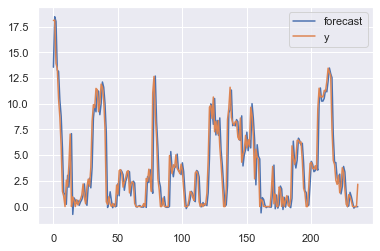

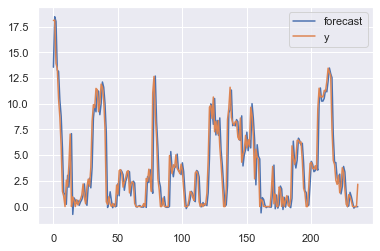

In [76]:
model_fit.plot_predict()

In [77]:
df

,data
0,13.599367
1,18.096519
2,18.134954
3,13.914314
4,13.427773
5,10.456230
6,8.667655
7,5.826604
8,1.470070
9,0.997118
